In [82]:
# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Extend PATH Variable
import sys
sys.path.append("src/")

# NanoNets Simulation Tool
import nanonets
import nanonets_utils

# Plot Colors
blue_color  = '#348ABD'
red_color   = '#A60628'

(<Figure size 350x262.5 with 1 Axes>, <Axes: >)

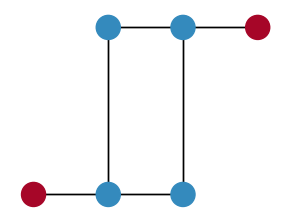

In [83]:
# Example: Cubic Network
network_topology = "cubic"

# Network Parameter
topology_parameter = {
    "Nx"    : 2,
    "Ny"    : 2,
    "Nz"    : 1,
    "e_pos" : [[0,0,0],[1,1,0]]
}

# Network Class Object
np_network_cubic = nanonets.simulation(network_topology=network_topology, topology_parameter=topology_parameter)
nanonets_utils.display_network(np_network_cubic)

In [103]:
sim_dic ={
    'error_th'        : 0.05,
    'max_jumps'       : 1000000,
    'eq_steps'        : 1000,
    'jumps_per_stat'  : 10000}

In [104]:
voltages        = np.zeros(shape=(600,3))
voltages[:,0]   = np.linspace(-0.1,0.1,600)

np_network_cubic = nanonets.simulation(network_topology=network_topology, topology_parameter=topology_parameter)
np_network_cubic.run_const_voltages(voltages=voltages, target_electrode=1, save_th=0.1, output_potential=False, sim_dic=sim_dic)

df1      = pd.DataFrame(np.hstack((voltages,np_network_cubic.return_output_values())))
df1[7]   = np_network_cubic.return_potential_landscape()[:,5]
df1      = df1.sort_values(by=0)
df1

In [92]:
ele_charge  = 0.160217662
c_inv       = np_network_cubic.inv_capacitance_matrix

def free_energy1(pot):
    return -ele_charge*pot + (ele_charge*ele_charge/2)*c_inv[3,3]

def free_energy2(pot):
    return ele_charge*pot + (ele_charge*ele_charge/2)*c_inv[3,3]

def tunnel_rate(df):

    R = 25e-12

    gamma       = np.zeros(len(df))
    gamma[df<0] = -df[df<0]/(ele_charge*ele_charge*R)

    return gamma

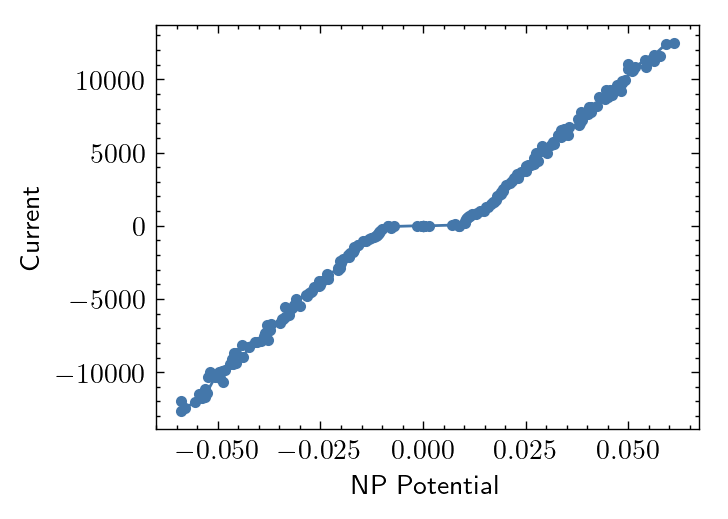

In [86]:
with plt.style.context(["science","bright"]):
    plt.figure(dpi=200)
    plt.plot(df1[7], df1[5], '.-')
    plt.xlabel('NP Potential')
    plt.ylabel('Current')

In [46]:
def pot_current_dep(voltages, n_jumps=10000, eq_steps=1000):

    pot_landscape   = np.zeros(n_jumps)
    time_vals       = np.zeros(n_jumps)
    pos_jumps       = np.zeros(n_jumps)
    neg_jumps       = np.zeros(n_jumps)
    rate_diffs      = np.zeros(n_jumps)

    np_network_cubic    = nanonets.simulation(network_topology=network_topology, topology_parameter=topology_parameter)

    # Based on current voltages get charges and potentials
    np_network_cubic.init_charge_vector(voltages)
    np_network_cubic.init_potential_vector(voltages)
    np_network_cubic.init_const_capacitance_values()
    np_network_cubic.np_target_electrode_electrostatic_properties(1)

    # Return Model Arguments
    inv_capacitance_matrix                                                                  = np_network_cubic.return_inv_capacitance_matrix()
    charge_vector                                                                           = np_network_cubic.return_charge_vector()
    potential_vector                                                                        = np_network_cubic.return_potential_vector()
    const_capacitance_values, const_capacitance_values_co1, const_capacitance_values_co2    = np_network_cubic.return_const_capacitance_values()
    N_electrodes, N_particles                                                               = np_network_cubic.return_particle_electrode_count()
    adv_index_rows, adv_index_cols, co_adv_index1, co_adv_index2, co_adv_index3             = np_network_cubic.return_advanced_indices()
    temperatures, temperatures_co                                                           = np_network_cubic.return_const_temperatures(T=0.0)
    resistances, resistances_co1, resistances_co2                                           = np_network_cubic.return_random_resistances(R=np_network_cubic.res_info['mean_R'], Rstd=np_network_cubic.res_info['std_R'])
    idx_np_target, C_np_self, C_np_target                                                   = np_network_cubic.return_output_electrostatics()

    # Pass all model arguments into Numba optimized Class
    model = nanonets.model_class(charge_vector, potential_vector, inv_capacitance_matrix, const_capacitance_values, const_capacitance_values_co1, const_capacitance_values_co2,
                            temperatures, temperatures_co, resistances, resistances_co1, resistances_co2, adv_index_rows, adv_index_cols, co_adv_index1, co_adv_index2,
                            co_adv_index3, N_electrodes, N_particles, C_np_target, C_np_self)
    
    model.calc_potentials()

    for i in range(eq_steps):
        
        random_number1  = np.random.rand()
        random_number2  = np.random.rand()
        model.calc_tunnel_rates_zero_T()
        model.select_event(random_number1, random_number2)

    model.time = 0.0

    rate_index1 = np.where(np_network_cubic.adv_index_cols == 1)[0][0]
    rate_index2 = np.where(np_network_cubic.adv_index_rows == 1)[0][0]

    for i in range(n_jumps):

        t1 = model.time
        
        pot_landscape[i]= model.potential_vector[5]
        
        random_number1  = np.random.rand()
        random_number2  = np.random.rand()
        model.calc_tunnel_rates_zero_T()
        rate_diffs[i] = model.tunnel_rates[rate_index1] - model.tunnel_rates[rate_index2]
        model.select_event(random_number1, random_number2)

        np1 = model.adv_index_rows[model.jump]
        np2 = model.adv_index_cols[model.jump]

        # If jump from target electrode
        if (np1 == 1):
            neg_jumps[i] = 1
            
        # If jump towards target electrode
        if (np2 == 1):
            pos_jumps[i] = 1
        
        t2 = model.time

        time_vals[i] = t2-t1
    
    return pd.DataFrame((np.array(pot_landscape),np.sum(np.array(time_vals)),pos_jumps-neg_jumps, np.array(rate_diffs))).T

In [94]:
def pot_current_dep(voltages, n_jumps=10000, eq_steps=1000):

    pot_landscape   = np.zeros(n_jumps)
    time_vals       = np.zeros(n_jumps)
    pos_jumps       = np.zeros(n_jumps)
    neg_jumps       = np.zeros(n_jumps)
    rate_diffs      = np.zeros(n_jumps)

    np_network_cubic    = nanonets.simulation(network_topology=network_topology, topology_parameter=topology_parameter)

    # Based on current voltages get charges and potentials
    np_network_cubic.init_charge_vector(voltages)
    np_network_cubic.init_potential_vector(voltages)
    np_network_cubic.init_const_capacitance_values()
    np_network_cubic.np_target_electrode_electrostatic_properties(1)

    # Return Model Arguments
    inv_capacitance_matrix                                                                  = np_network_cubic.return_inv_capacitance_matrix()
    charge_vector                                                                           = np_network_cubic.return_charge_vector()
    potential_vector                                                                        = np_network_cubic.return_potential_vector()
    const_capacitance_values, const_capacitance_values_co1, const_capacitance_values_co2    = np_network_cubic.return_const_capacitance_values()
    N_electrodes, N_particles                                                               = np_network_cubic.return_particle_electrode_count()
    adv_index_rows, adv_index_cols, co_adv_index1, co_adv_index2, co_adv_index3             = np_network_cubic.return_advanced_indices()
    temperatures, temperatures_co                                                           = np_network_cubic.return_const_temperatures(T=0.0)
    resistances, resistances_co1, resistances_co2                                           = np_network_cubic.return_random_resistances(R=np_network_cubic.res_info['mean_R'], Rstd=np_network_cubic.res_info['std_R'])
    idx_np_target, C_np_self, C_np_target                                                   = np_network_cubic.return_output_electrostatics()

    # Pass all model arguments into Numba optimized Class
    model = nanonets.model_class(charge_vector, potential_vector, inv_capacitance_matrix, const_capacitance_values, const_capacitance_values_co1, const_capacitance_values_co2,
                            temperatures, temperatures_co, resistances, resistances_co1, resistances_co2, adv_index_rows, adv_index_cols, co_adv_index1, co_adv_index2,
                            co_adv_index3, N_electrodes, N_particles, C_np_target, C_np_self)
    
    model.calc_potentials()

    for i in range(eq_steps):
        
        random_number1  = np.random.rand()
        random_number2  = np.random.rand()
        model.calc_tunnel_rates_zero_T()
        model.select_event(random_number1, random_number2)

    model.time = 0.0

    rate_index1 = np.where(np_network_cubic.adv_index_cols == 1)[0][0]
    rate_index2 = np.where(np_network_cubic.adv_index_rows == 1)[0][0]

    for i in range(n_jumps):

        t1 = model.time
        
        pot_landscape[i]= model.potential_vector[5]
        
        random_number1  = np.random.rand()
        random_number2  = np.random.rand()
        model.calc_tunnel_rates_zero_T()
        rate_diffs[i] = model.tunnel_rates[rate_index1] - model.tunnel_rates[rate_index2]
        model.select_event(random_number1, random_number2)

        np1 = model.adv_index_rows[model.jump]
        np2 = model.adv_index_cols[model.jump]

        # If jump from target electrode
        if (np1 == 1):
            neg_jumps[i] = 1
            
        # If jump towards target electrode
        if (np2 == 1):
            pos_jumps[i] = 1
        
        t2 = model.time

        time_vals[i] = t2-t1
    
    return [np.mean(np.array(pot_landscape)),np.sum(np.array(time_vals)),np.sum(pos_jumps-neg_jumps), np.mean(np.array(rate_diffs))*10**(-6)]

In [95]:
n_jumps     = 10000
eq_steps    = 1000
vals        = []

for V in np.linspace(-0.1,0.1,600):

    voltages    = np.array([V,0.0,0.0])
    vals.append(pot_current_dep(voltages, n_jumps, eq_steps))
    
df = pd.DataFrame(vals)
df

,0,1,2,3
0,-0.027560,5.545483e-07,-2499.0,-4494.563435
1,-0.026933,5.499706e-07,-2495.0,-4348.587157
2,-0.026882,5.538153e-07,-2496.0,-4334.673569
3,-0.026920,5.481441e-07,-2497.0,-4335.372811
4,-0.027147,5.667313e-07,-2497.0,-4406.208689
...,...,...,...,...
595,0.027165,5.519954e-07,2497.0,4419.555492
596,0.027597,5.665890e-07,2496.0,4495.358103
597,0.027208,5.421759e-07,2493.0,4403.570191
598,0.027317,5.541790e-07,2495.0,4437.880964


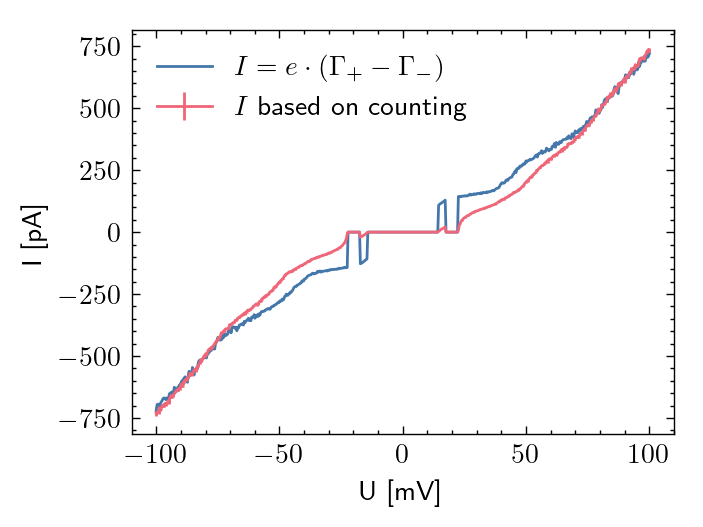

In [106]:
with plt.style.context(["science","bright"]):
    
    plt.figure(dpi=200)
    plt.plot(np.linspace(-0.1,0.1,600)*1000, df[3]*ele_charge, '-', label='$I = e \cdot (\Gamma_+ - \Gamma_-)$')
    plt.errorbar(np.linspace(-0.1,0.1,600)*1000, df1[5]*ele_charge, df1[6]*ele_charge, label='$I$ based on counting')

    plt.ylabel('I [pA]')
    plt.xlabel('U [mV]')
    plt.legend()

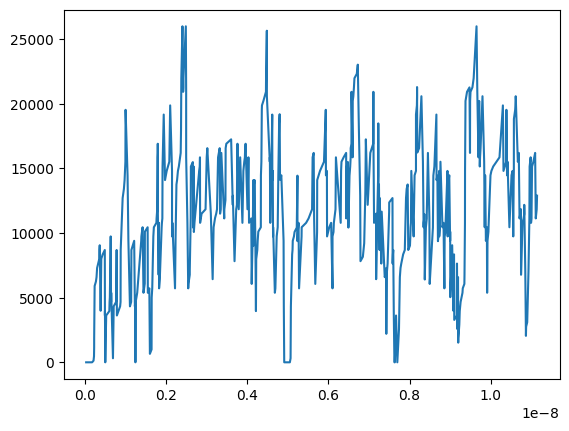

In [44]:
plt.plot(np.cumsum(df[1]), df[3]*10**(-6))

In [45]:
free_e = free_energy(df[0])

with plt.style.context(["science","bright"]):
    
    plt.figure(dpi=200)
    plt.plot(df[0], '.-')
    plt.plot(free_e)
    plt.vlines(np.arange(len(df[1]))[df[2].values == 1], ymin=0, ymax=0.15, color='black', lw=0.5)
    plt.xlim(0,100)
    plt.ylim(0, 0.1)
    plt.ylabel('Potential')
    plt.xlabel('Jumps')

NameError: name 'free_energy' is not defined

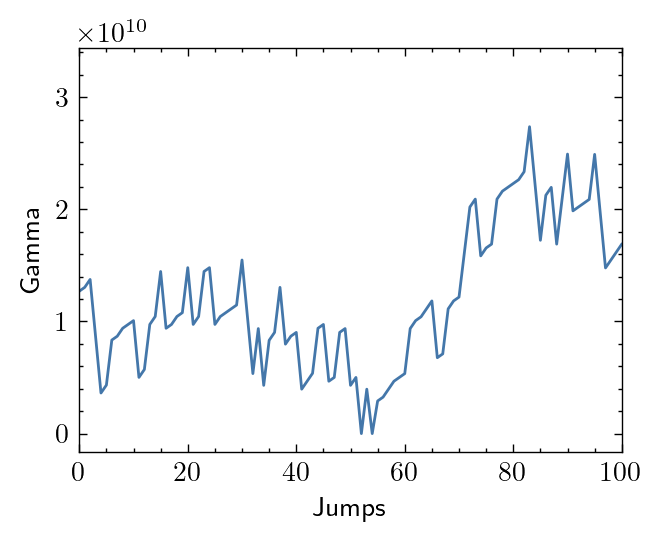

In [125]:
gamma = tunnel_rate(free_e)

with plt.style.context(["science","bright"]):
    plt.figure(dpi=200)
    plt.plot(gamma)
    plt.vlines(np.arange(len(df[1]))[df[2].values == 1], ymin=0, ymax=0.15, color='black', lw=0.5)
    plt.xlim(0,100)
    plt.ylabel('Gamma')
    plt.xlabel('Jumps')

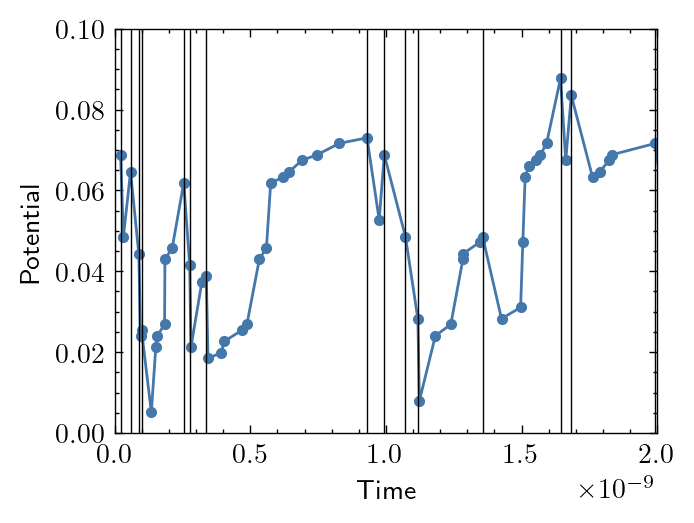

In [111]:
with plt.style.context(["science","bright"]):
    plt.figure(dpi=200)
    plt.plot(np.cumsum(df[1]),df[0], '.-')
    plt.vlines(np.cumsum(df[1]).values[df[2].values == 1], ymin=0, ymax=0.15, color='black', lw=0.5)
    plt.ylim(0, 0.1)
    plt.xlim(0,2e-9)
    plt.ylabel('Potential')
    plt.xlabel('Time')

(0.0, 100.0)

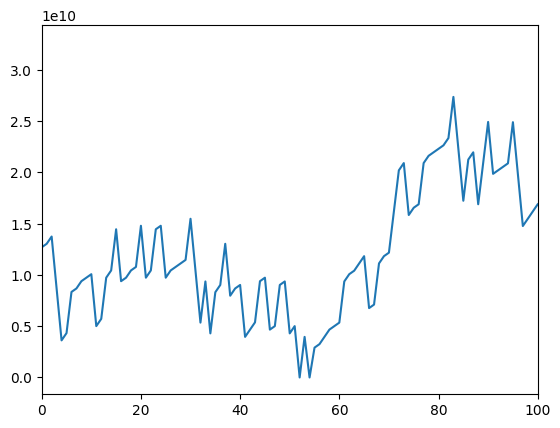

In [127]:
I = tunnel_rate(free_energy1(df[0])) - tunnel_rate(free_energy2(df[0]))
plt.plot(I)
plt.xlim(0,100)

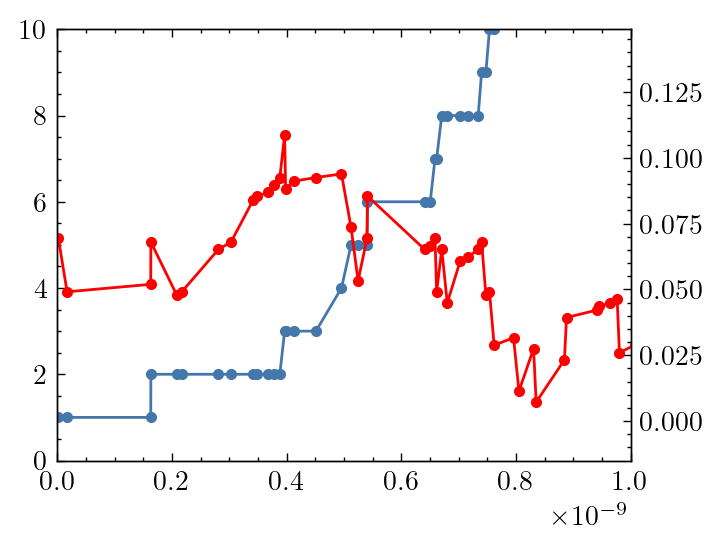

In [271]:
with plt.style.context(["science","bright"]):

    fig = plt.figure(dpi=200,layout='constrained')
    ax  = fig.add_subplot()
    ax.plot(np.cumsum(df[1]), np.cumsum(df[2]), '.-')
    ax.set_xlim(0,1e-9)
    ax.set_ylim(0,10)

    ax2 = ax.twinx()
    ax2.plot(np.cumsum(df[1]), df[0], '.-', c='red')
    ax2.set_xlim(0,1e-9)

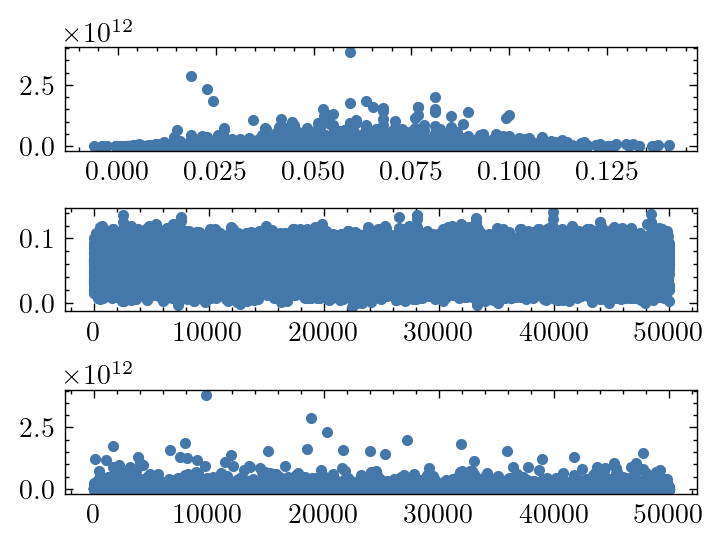

In [250]:
vals_per_bin    = 2
df[3]           = np.repeat(np.arange(1,n_jumps/vals_per_bin+1),vals_per_bin)
df_bins         = df[[0,3]].groupby(by=3).mean()
df_bins[1]      = df[[2,3]].groupby(by=3).sum()[2]/df[[1,3]].groupby(by=3).sum()[1]

with plt.style.context(["science","bright"]):

    fig = plt.figure(dpi=200,layout='constrained')
    ax  = fig.add_subplot(3,1,1)
    ax.plot(df_bins[0], df_bins[1], '.')

    ax  = fig.add_subplot(3,1,2)
    ax.plot(df_bins[0], '.')

    ax  = fig.add_subplot(3,1,3)
    ax.plot(df_bins[1], '.')